# Importing the dependencies

In [9]:
!pip install opendatasets --quiet

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.datasets import MNIST


%matplotlib inline
# torch.manual_seed(42)

In [11]:
import opendatasets as od
import os

In [12]:
url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: royalalbert
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:07<00:00, 51.9MB/s]


# Creating the Dataloaders, performing image augmentation and channel normalization

In [13]:
image_size = 64
batch_size = 256
imagenet_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [14]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [15]:
DATA_DIR = './animefacedataset/images/'
print(os.listdir(DATA_DIR)[:10])

['1773_2001.jpg', '56721_2017.jpg', '9506_2004.jpg', '39431_2012.jpg', '10412_2004.jpg', '17908_2007.jpg', '35475_2011.jpg', '22889_2008.jpg', '49705_2015.jpg', '44147_2013.jpg']


In [16]:
# yo classification haina image lai augment garne. yesma jasto image ma train vaxa testai generate hune ho. so, augment gare testai type
# -image aauxa. So, dont augment the images

train_path = 'animefacedataset/'

train_ds = ImageFolder(train_path, transform=T.Compose([
    T.Resize((image_size,image_size)),
    # T.RandomCrop(image_size),   
    # T.Pad(10, padding_mode = 'reflect'),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),T.Normalize(*imagenet_stats)]))

In [17]:
len(train_ds)

63565

In [18]:
def denormalize_the_images(image, mean, std):
  if (len(image.shape) == 3):
    image = image.unsqueeze(0)
  mean = torch.tensor(mean).reshape(1,3,1,1) # image ta matrix tensor ma xa. so matrix multiply ra add garda shape eutai huna paryo nita
  std = torch.tensor(std).reshape(1,3,1,1)
  return image * std + mean

In [19]:
def displaying_image(img, label):
  # print("Label is: ", label," or ",classes[label])
  denormalized_image_tensor = denormalize_the_images(img, *imagenet_stats)[0]
  plt.imshow(denormalized_image_tensor.permute(1,2,0))

In [20]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize_the_images(images.detach()[:nmax], *imagenet_stats), nrow=8).permute(1, 2, 0))

In [21]:
dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([256, 3, 64, 64])


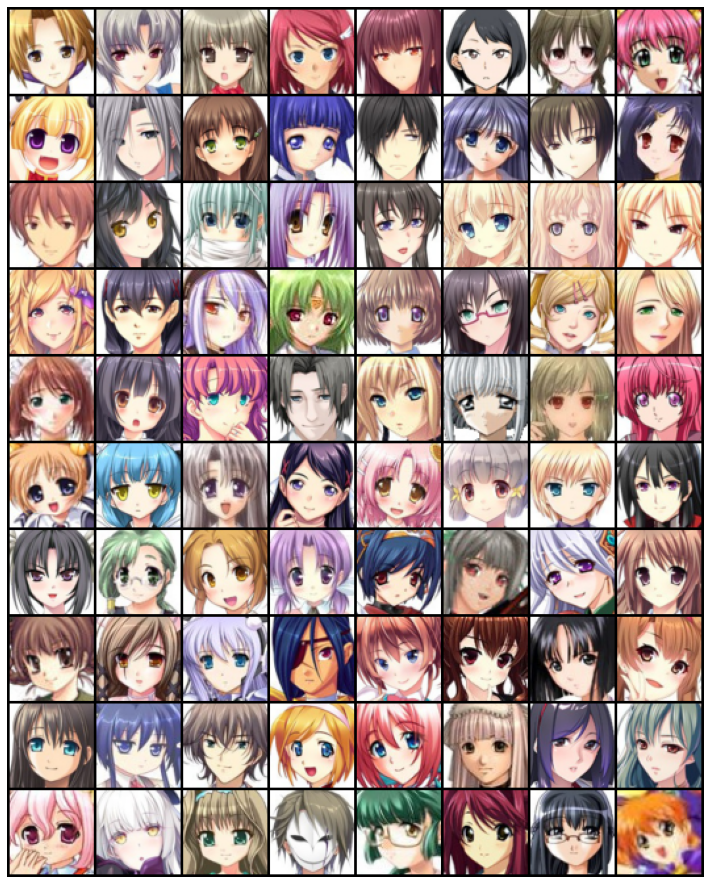

In [22]:
for images, _ in dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    images = denormalize_the_images(images[:80],*imagenet_stats)
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

# Creating Generator and Discriminator Models

In [23]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [24]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(32),
    # nn.ReLU(True),
    # # out: 32 * 64 * 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(16),
    # nn.ReLU(True),
    # # out: 16 * 128 * 128

    # nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
xb.shape

torch.Size([256, 128, 1, 1])

In [26]:
fake_images = generator(xb)
print(fake_images.shape)

torch.Size([256, 3, 64, 64])


# Using GPU

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [28]:
train_dl = DeviceDataLoader(dl,device)

In [29]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

# Training our Model

In [30]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss =  F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # fake_images = torchvision.transforms.Resize(84)(fake_images)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss =  F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [31]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # fake_images = torchvision.transforms.Resize(84)(fake_images)  
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss =  F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Setting Image Helper Functions

In [32]:
from torchvision.utils import save_image

In [33]:
import os

In [34]:
sample_dir = 'Generated_Images'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
import numpy as np
stats = torch.from_numpy(np.array([imagenet_stats]));stats
stats = stats.to(device='cuda')

In [36]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    # denormalize_the_images(images[:nmax],*stats)
    save_image(denormalize_the_images(fake_images, *stats[0]), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


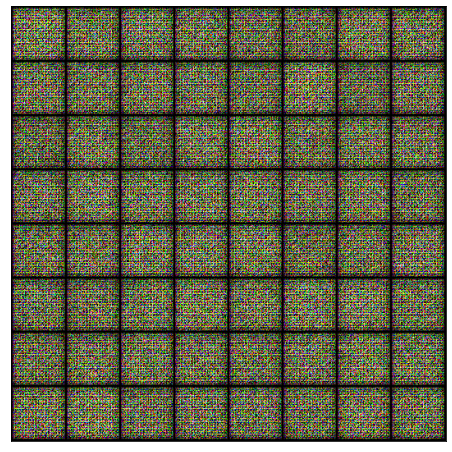

In [38]:
save_samples(0, fixed_latent)

# Full training loop

In [39]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
def fit(start_epoch,end_epoch, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(start_epoch, end_epoch):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, end_epoch, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:
lr = 0.0002
start_epoch = 0
end_epoch = 20

In [42]:
history = fit(start_epoch,end_epoch, lr)

  0%|          | 0/249 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/20], loss_g: 2.9883, loss_d: 0.5573, real_score: 0.7029, fake_score: 0.1365
Saving generated-images-0001.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 5.4944, loss_d: 1.2580, real_score: 0.3947, fake_score: 0.0038
Saving generated-images-0002.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 6.6242, loss_d: 0.6896, real_score: 0.9068, fake_score: 0.3992
Saving generated-images-0003.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 4.3806, loss_d: 0.5242, real_score: 0.7775, fake_score: 0.1964
Saving generated-images-0004.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 4.0204, loss_d: 0.3249, real_score: 0.8368, fake_score: 0.1092
Saving generated-images-0005.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 4.0095, loss_d: 0.2389, real_score: 0.9320, fake_score: 0.1429
Saving generated-images-0006.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 7.6062, loss_d: 0.5557, real_score: 0.9867, fake_score: 0.3810
Saving generated-images-0007.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 5.7673, loss_d: 0.4510, real_score: 0.7048, fake_score: 0.0066
Saving generated-images-0008.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 4.2654, loss_d: 0.9832, real_score: 0.4599, fake_score: 0.0018
Saving generated-images-0009.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 6.5689, loss_d: 0.4393, real_score: 0.9566, fake_score: 0.2911
Saving generated-images-0010.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 3.2913, loss_d: 0.4610, real_score: 0.7894, fake_score: 0.1684
Saving generated-images-0011.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 6.5674, loss_d: 0.3578, real_score: 0.9775, fake_score: 0.2669
Saving generated-images-0012.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 4.4471, loss_d: 0.1766, real_score: 0.8943, fake_score: 0.0368
Saving generated-images-0013.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 2.7017, loss_d: 0.3876, real_score: 0.7313, fake_score: 0.0215
Saving generated-images-0014.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 3.1984, loss_d: 0.1399, real_score: 0.9267, fake_score: 0.0551
Saving generated-images-0015.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 4.5557, loss_d: 0.3045, real_score: 0.8855, fake_score: 0.1492
Saving generated-images-0016.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 4.1101, loss_d: 0.1972, real_score: 0.9237, fake_score: 0.1028
Saving generated-images-0017.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 3.4090, loss_d: 0.1963, real_score: 0.8551, fake_score: 0.0265
Saving generated-images-0018.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 4.0303, loss_d: 0.2395, real_score: 0.9162, fake_score: 0.1309
Saving generated-images-0019.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 4.2065, loss_d: 0.2738, real_score: 0.9420, fake_score: 0.1777
Saving generated-images-0020.png


In [44]:
history1 = fit(20,50, lr)

  0%|          | 0/249 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [21/50], loss_g: 1.0976, loss_d: 0.6683, real_score: 0.5883, fake_score: 0.0063
Saving generated-images-0021.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.5745, loss_d: 0.5429, real_score: 0.8230, fake_score: 0.2467
Saving generated-images-0022.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.4017, loss_d: 0.2471, real_score: 0.8846, fake_score: 0.0996
Saving generated-images-0023.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 2.0436, loss_d: 0.7660, real_score: 0.5890, fake_score: 0.0797
Saving generated-images-0024.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.3198, loss_d: 0.2098, real_score: 0.8772, fake_score: 0.0617
Saving generated-images-0025.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.6334, loss_d: 0.2078, real_score: 0.8697, fake_score: 0.0539
Saving generated-images-0026.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.0321, loss_d: 0.1416, real_score: 0.9225, fake_score: 0.0480
Saving generated-images-0027.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 1.4386, loss_d: 1.1205, real_score: 0.3990, fake_score: 0.0007
Saving generated-images-0028.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.4314, loss_d: 0.4274, real_score: 0.6884, fake_score: 0.0089
Saving generated-images-0029.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.1542, loss_d: 0.2849, real_score: 0.9345, fake_score: 0.1783
Saving generated-images-0030.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 8.5001, loss_d: 0.8301, real_score: 0.9966, fake_score: 0.5020
Saving generated-images-0031.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.2206, loss_d: 0.2635, real_score: 0.9761, fake_score: 0.1905
Saving generated-images-0032.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.6144, loss_d: 0.1320, real_score: 0.9317, fake_score: 0.0536
Saving generated-images-0033.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.9268, loss_d: 0.1380, real_score: 0.9469, fake_score: 0.0744
Saving generated-images-0034.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.4997, loss_d: 0.1336, real_score: 0.9550, fake_score: 0.0786
Saving generated-images-0035.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.9433, loss_d: 0.0606, real_score: 0.9682, fake_score: 0.0237
Saving generated-images-0036.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.5304, loss_d: 0.1980, real_score: 0.9653, fake_score: 0.1378
Saving generated-images-0037.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 9.7945, loss_d: 1.1523, real_score: 0.9993, fake_score: 0.5981
Saving generated-images-0038.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 8.2792, loss_d: 0.6134, real_score: 0.9966, fake_score: 0.3894
Saving generated-images-0039.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.8678, loss_d: 0.3553, real_score: 0.8959, fake_score: 0.1868
Saving generated-images-0040.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.1402, loss_d: 0.3337, real_score: 0.9688, fake_score: 0.2316
Saving generated-images-0041.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.0111, loss_d: 0.0500, real_score: 0.9743, fake_score: 0.0226
Saving generated-images-0042.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.0364, loss_d: 0.1404, real_score: 0.9740, fake_score: 0.0997
Saving generated-images-0043.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 1.5022, loss_d: 0.7544, real_score: 0.5398, fake_score: 0.0088
Saving generated-images-0044.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.0364, loss_d: 0.3410, real_score: 0.8407, fake_score: 0.1313
Saving generated-images-0045.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.0578, loss_d: 0.3286, real_score: 0.9194, fake_score: 0.1877
Saving generated-images-0046.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.4427, loss_d: 0.0456, real_score: 0.9919, fake_score: 0.0349
Saving generated-images-0047.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.2738, loss_d: 0.2450, real_score: 0.9978, fake_score: 0.1934
Saving generated-images-0048.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.1429, loss_d: 0.1577, real_score: 0.9735, fake_score: 0.1117
Saving generated-images-0049.png


  0%|          | 0/249 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 5.5912, loss_d: 0.1576, real_score: 0.9680, fake_score: 0.1097
Saving generated-images-0050.png


In [45]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Generator_weights_anime_stage1.pth')
torch.save(discriminator.state_dict(), 'Discriminator_weights_anime_stage1.pth')

In [46]:
from google.colab import files
files.download("/content/Generator_weights_anime_stage1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
from google.colab import files
files.download("/content/Discriminator_weights_anime_stage1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
!zip -r /content/Generated100.zip /content/Generated_Images

  adding: content/Generated_Images/ (stored 0%)
  adding: content/Generated_Images/generated-images-0016.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0038.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0010.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0050.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0029.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0039.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0041.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0009.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0047.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0044.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0012.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0013.png (deflated 0%)
  adding: content/Generated_Images/generated-images-

In [49]:
from google.colab import files
files.download("/content/Generated100.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Thank you for visiting
# Please, like, follow, and view my other projects as well